# Разработка сверточной нейронной сети с использованием PyTorch

In [174]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import numpy as np
import os
import time
import graphviz
from torchview import draw_graph
from matplotlib import pyplot as plot
from torchvision.datasets import CIFAR10
import graphviz
from torchview import draw_graph

Загрузка данных

In [175]:
transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ]
)

train_dataset = torchvision.datasets.CIFAR10(
    root = os.getcwd(), train = True, download = True,
    transform = transforms
)
test_dataset = torchvision.datasets.CIFAR10(
    root = os.getcwd(), train = False, download = True,
    transform = transforms
)

Files already downloaded and verified
Files already downloaded and verified


Визуализация датасета

All image shapes are valid ((32, 32, 3))
All image shapes are valid ((32, 32, 3))


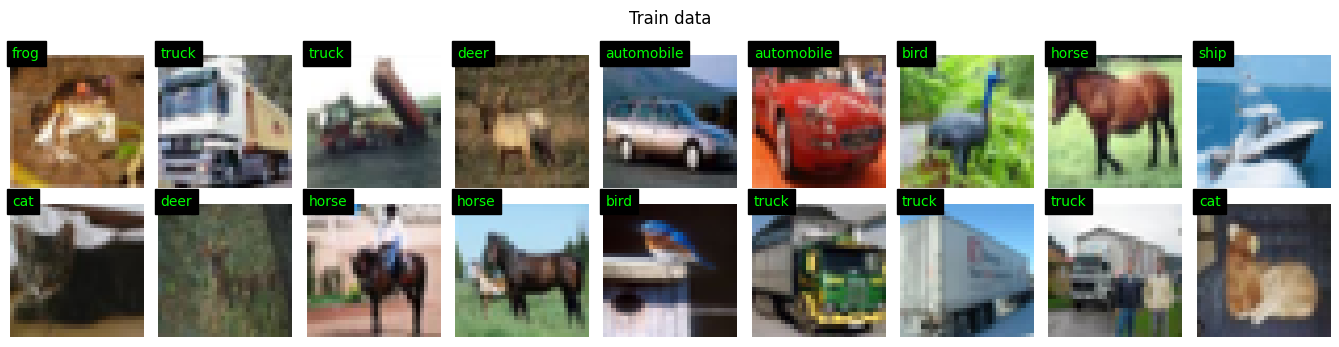

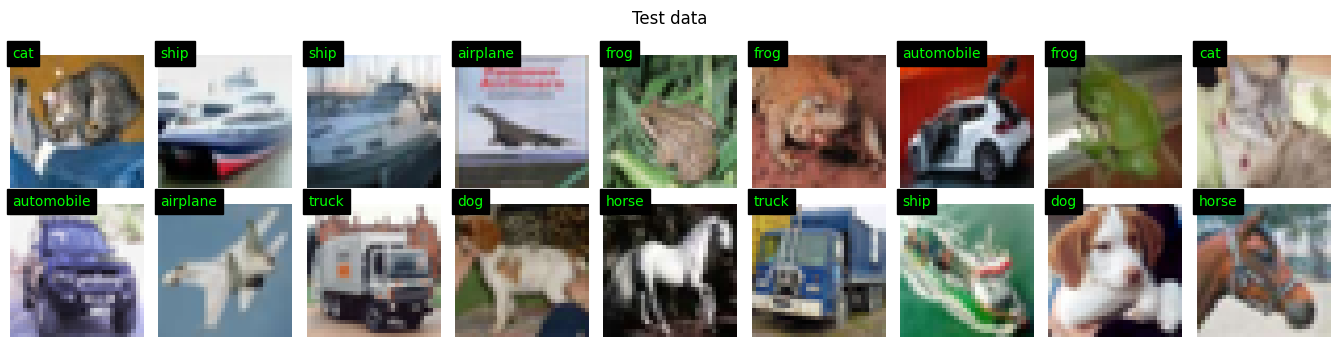

In [176]:
def show_images(dataset: CIFAR10, title: str, nx: int = 9, ny: int = 2):
    fig, axes = plt.subplots(
        ny,
        nx,
        figsize=(nx*1.5, ny*1.5 + 0.5),
        sharex=True,
        sharey=True,
        tight_layout=True,
    )

    fig.suptitle(title)

    input_shape = (32, 32, 3)

    for ax, image, label in zip(axes.flat, dataset.data, dataset.targets):
        if image.shape != input_shape:
            raise ValueError("Wrong input shape!")

        ax.imshow(image, label=label)
        ax.set_axis_off()
        ax.text(0, 0, train_dataset.classes[label], color="lime", backgroundcolor="black")
    else:
        print(f"All image shapes are valid ({input_shape})")

show_images(train_dataset, "Train data")
show_images(test_dataset, "Test data")

In [177]:
print('Размерность входных данных тренировочной выборки: {}'.format(train_dataset[0][0].numpy().shape))
print('Размерность входных данных тестовой выборки: {}'.format(test_dataset[0][0].numpy().shape))

print('Размерность ответов тренировочной выборки: {}'.format(len(train_dataset)))
print('Размерность ответов тестовой выборки: {}'.format(len(test_dataset)))

print('Тип входных данных {}'.format(train_dataset[0][0].numpy().dtype))

Размерность входных данных тренировочной выборки: (3, 32, 32)
Размерность входных данных тестовой выборки: (3, 32, 32)
Размерность ответов тренировочной выборки: 50000
Размерность ответов тестовой выборки: 10000
Тип входных данных float32


In [178]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

Реализация сети

In [179]:
class ConvolutionalNeuralNetwork(torch.nn.Module):

    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, 3)
        self.conv2 = torch.nn.Conv2d(64, 128, 3)
        self.conv3 = torch.nn.Conv2d(128, 256, 3)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(64 * 4 * 4, 128)
        self.fc2 = torch.nn.Linear(128, 256)
        self.fc3 = torch.nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.nn.functional.relu(self.conv1(x)))
        x = self.pool(torch.nn.functional.relu(self.conv2(x)))
        x = self.pool(torch.nn.functional.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.nn.functional.log_softmax(x, dim=1)

Визуализация сети

In [180]:
cnn_model = ConvolutionalNeuralNetwork()
cnn_model

ConvolutionalNeuralNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

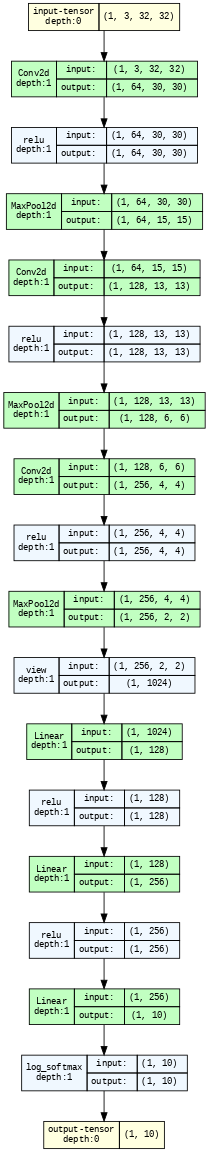

In [181]:
graphviz.set_jupyter_format('png')
model_graph = draw_graph(cnn_model, input_size=(1,3,32,32), expand_nested=True)
model_graph.visual_graph

Обучение модели

In [182]:
learning_rate = 0.1 # скорость обучения
num_epochs = 20 # количество эпох

# Выбор устройства для вычислений
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)
# Функция ошибки на этапе обучения
loss_function = torch.nn.CrossEntropyLoss()
# Метод оптимизации для обучения параметров
optimizer = torch.optim.SGD(cnn_model.parameters(), lr = learning_rate)

# Функция вычисления точности top-1
def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader: # проход по всем данным
            # Получение выхода сети на входной пачке изображений
            outputs = model(images)
            # Выбор предсказанных меток с максимальной достоверностью.
            # outputs.data - объект типа torch.tensor, двумерный тензор, массив
            # векторов достоверности принадлежности каждому из 10 допустимых классов
            # (размерность 0 - номер изображения в пачке, размерность 1 - номер класса);
            # predicted - объект типа torch.tensor (одномерный тензор меток классов).
            # Выбор максимальных значений выполняется по первой размерности
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0) # количество изображений, совпадает с batch_size
            tp += (predicted == labels).sum() # определение количества корректных совпадений
    return tp / n

start_time = time.time()
for epoch in range(num_epochs):  # проход по эпохам
    for i, (images, labels) in enumerate(trainloader): # получение пачки тренировочных данных
        # Загрузка данных на устройство
        images = images.requires_grad_().to(device)
        labels = labels.to(device)
        # Прямой проход
        outputs = cnn_model(images) # вычисление выхода сети
        loss = loss_function(outputs, labels) # вычисление функции ошибки, loss.item() дает значение
        # Обратный проход
        optimizer.zero_grad() # обнуление всех вычисляемых градиентов
        loss.backward() # вычисление градиента функции ошибки
        optimizer.step() # обновление параметров модели

    # Логирование метрики качества на тренировочных данных по завершении эпохи
    print('Epoch[{}]: accuracy = {} loss = {}'.
          format(epoch, get_accuracy(trainloader, cnn_model), loss))

end_time = time.time()

elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')

Epoch[0]: accuracy = 0.38218000531196594 loss = 1.6477504968643188
Epoch[1]: accuracy = 0.4836199879646301 loss = 1.5923248529434204
Epoch[2]: accuracy = 0.5837799906730652 loss = 1.1679807901382446
Epoch[3]: accuracy = 0.6431199908256531 loss = 1.0532994270324707
Epoch[4]: accuracy = 0.7206599712371826 loss = 0.812303364276886
Epoch[5]: accuracy = 0.7583600282669067 loss = 0.8195084929466248
Epoch[6]: accuracy = 0.774399995803833 loss = 0.8230703473091125
Epoch[7]: accuracy = 0.7825000286102295 loss = 0.7844913601875305
Epoch[8]: accuracy = 0.8704000115394592 loss = 0.43689635396003723
Epoch[9]: accuracy = 0.8719000220298767 loss = 0.500250518321991
Epoch[10]: accuracy = 0.8746799826622009 loss = 0.5463619828224182
Epoch[11]: accuracy = 0.9216799736022949 loss = 0.36696770787239075
Epoch[12]: accuracy = 0.9448999762535095 loss = 0.31630969047546387
Epoch[13]: accuracy = 0.949400007724762 loss = 0.26522257924079895
Epoch[14]: accuracy = 0.9450600147247314 loss = 0.2625185251235962
Epoc

In [186]:
print('Test accuracy: {}'.format(get_accuracy(testloader, cnn_model)))

Test accuracy: 0.7358999848365784
